# Covid-19 Risk Classification in Malaysia  
## Part 1: Introduction  

### Objective  
The objective of this project is to **classify next week's Covid-19 risk levels in Malaysia** into two categories:  
- **High risk**: If daily new cases exceed the `RISK_THRESHOLD` (default: 4,000, based on MCO 3.0 policy trigger)  
- **Low risk**: Otherwise  

This classification problem will be approached using **three supervised learning methods**:  
1. Linear Regression  
2. K-Nearest Neighbors (KNN)  
3. Logistic Regression  

### Motivation  
- During the Covid-19 pandemic, understanding the risk level of infection ahead of time (1 week ahead) was crucial for decision-making in healthcare, government policies, and public awareness.  
- On **12 May 2021**, the Malaysian government announced **MCO 3.0** as daily new cases exceeded **4,000**, later escalating to a **full lockdown on 1 June 2021** when cases surged above **9,000**.  
- This project uses the **4,000-case threshold** as a real-world benchmark for classifying **high-risk periods**, making predictions more interpretable and policy-relevant.  
- By comparing different machine learning models, we aim to evaluate which method is most effective for predicting risk levels, balancing **accuracy, interpretability, and computational efficiency**.  

### Dataset  
Source: [Ministry of Health Malaysia (MoH) GitHub Repository](https://github.com/MoH-Malaysia/covid19-public)  

We will use **country-level daily data**.

For this project, a **6-month consecutive date range (1 March 2021 – 31 August 2021)** was selected.  
- The **median point of this range is 1 June 2021**, which coincides with the start of the **Full Movement Control Order (FMCO)**, making this window highly representative of Malaysia’s Covid-19 crisis.  
- This ensures sufficient training samples while keeping the experiment focused on a **critical policy period**.  

### Methodology Overview  
The following steps will be performed in this notebook:  
1. **Data Collection & Cleaning** – Load Covid-19 datasets and preprocess them  
2. **Feature Engineering** – Select features, transform & scale data  
3. **Dataset Splitting** – Divide into training, validation, and testing sets  
4. **Model Training** – Train three models: Linear Regression, KNN, Logistic Regression  
5. **Plotting & Evaluation** – Evaluate with metrics & visualize ROC, PR, and error curves  
6. **Analysis & Conclusion** – Compare models and highlight key findings  

### Hyperparameters to Tune  
Each model will be trained with baseline parameters and then fine-tuned with the following hyperparameters:  

- **Linear Regression (Kotaro)**  
  - `alpha` → Regularization strength (for Ridge/Lasso)  
  - `penalty` → Type of regularization (`l1`, `l2`)  
  - `max_iter` → Maximum number of iterations for convergence  

- **K-Nearest Neighbors (Andrea)**  
  - `n_neighbors (k)` → Number of neighbors to consider  
  - `weights` → Uniform vs distance-based weighting  
  - `metric` → Distance measure (Euclidean, Manhattan, Minkowski)  

- **Logistic Regression (JeeSee)**  
  - `penalty` → Regularization type (`l1`, `l2`, `elasticnet`)  
  - `solver` → Optimization algorithm (`liblinear`, `lbfgs`, `saga`)  
  - `max_iter` → Maximum number of iterations for convergence  

### Evaluation Metrics  
We will compare all three models using:  
1. Accuracy  
2. Recall
3. Precision
4. Specificity
5. F1 Score
6. Area under Curve (AUC)
7. Training Speed

### Visualization  
Plots will be used to support evaluation:  
- ROC Curve  
- Precision-Recall Curve  
- Overfitting/Underfitting curves (Train vs Validation Errors)  


In [85]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set start date, end date, and risk threshold
START_DATE = pd.to_datetime("2021-03-01")
END_DATE = START_DATE + pd.DateOffset(months=6)
RISK_THRESHOLD = 4000


# Part 2: Data Collection & Cleaning

### Data Source
We will use official Malaysian Covid-19 datasets provided by the **Ministry of Health Malaysia (MoH)**, available on GitHub:  
[https://github.com/MoH-Malaysia/covid19-public](https://github.com/MoH-Malaysia/covid19-public)

### Selected Files
For this project, we will mainly use:
- `cases_malaysia.csv` → Daily Covid-19 cases (our primary feature for target creation)  
- `tests_malaysia.csv` → Daily testing numbers  
- `hospital.csv` → Hospitalization data  
- `icu.csv` → ICU utilization data  
- `vax_malaysia.csv` → Vaccination progress  

### Target Variable
We define the **binary classification target**:
- **High risk (1)** if `cases_new > RISKTHRESHOLD`  
- **Low risk (0)** otherwise


In [86]:
# Read the csv files
datasets = {
    "cases": pd.read_csv("cases_malaysia.csv"),
    "tests": pd.read_csv("tests_malaysia.csv"),
    "hospital": pd.read_csv("hospital.csv"),
    "icu": pd.read_csv("icu.csv"),
    "vax": pd.read_csv("vax_malaysia.csv"),
}

# Clean data
for name, df in datasets.items():
    # Select 6-month range
    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)].copy()

    # Group by date (and remove non-numeric columns)
    df = df.groupby("date").sum(numeric_only=True).reset_index()
    df = df.drop_duplicates(subset=["date"])

    # Remove columns that have no or a single distinct value only
    nunique = df.nunique()
    cols_to_drop = nunique[nunique <= 1].index
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    # Fill in empty entries in numerical columns
    df.fillna(0, inplace=True)

    # Assign cleaned data
    datasets[name] = df

# Merge datasets on date
from functools import reduce
df = reduce(
    lambda left, right: pd.merge(left, right, on="date", how="left"),
    datasets.values()
)

# Create binary target variable (risk level)
df["risk_level"] = (df["cases_new"] > RISK_THRESHOLD).astype(int)

# Sort by date
df = df.sort_values("date").reset_index(drop=True)

df

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_child,...,sinovac3,astra1,astra2,sinopharm1,sinopharm2,cansino,pending1,pending2,pending3,risk_level
0,2021-03-01,1828,7,2486,25538,962,1828,0,0,129,...,0,0,0,0,0,0,6,0,0,0
1,2021-03-02,1555,3,2528,24559,604,1555,0,0,114,...,0,0,0,0,0,0,0,0,0,0
2,2021-03-03,1745,2,2276,24021,867,1744,1,0,111,...,0,0,0,0,0,0,5,0,0,0
3,2021-03-04,2063,9,2922,23157,897,2062,1,0,159,...,0,0,0,0,0,0,4,3,0,0
4,2021-03-05,2154,5,3275,22030,1021,2151,3,0,193,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2021-08-28,22597,12,19492,268552,2551,10424,6856,5317,3188,...,0,12830,18525,0,0,6986,4,39,0,1
181,2021-08-29,20579,7,20845,268001,2595,10009,5648,4922,3025,...,0,12655,16305,0,0,7745,26,16,0,1
182,2021-08-30,19268,16,21257,265718,2097,9325,5289,4654,2928,...,0,11007,20951,0,0,4263,32,15,0,1
183,2021-08-31,20897,1,18465,267868,1454,9490,5831,5576,2947,...,0,8730,21010,0,0,2566,56,15,0,1


## Part 3: Feature Engineering

We organize feature engineering into three subparts:
1. **Feature Selection** – select relevant numerical metrics and drop redundant/noisy columns.
2. **Feature Transformation** – scale features and handle skewed distributions to improve model performance.
3. **Feature Creation (Lagging)** – create lag features from the past 8–14 days to predict next week's risk.

### Part 3.1: Feature Selection

**Objective:** Reduce noise and prevent overfitting by selecting relevant numerical features.

**Reasoning:**
- Drop highly detailed or redundant columns, including:
  - **Case breakdowns** by age or vaccination type (correlated with total cases)
  - **ICU/ventilator subcategories** (aggregated in broader metrics)
  - **Vaccination subgroups** (aggregated)
  - **Date column** to avoid leakage
  - **Target columns** (`risk_level`, `risk_level_next_week`) to prevent using future information
- This ensures the model focuses on metrics most predictive of next week’s risk level.

**Columns to Drop:**  
Date-related: `date`  
Cases breakdowns: `cases_import`, `cases_recovered`, `cases_cluster`, `cases_unvax`, …  
Hospital/ICU: `admitted_pui`, `admitted_covid`, …  
Vaccination subgroups: `daily_partial_adol`, …  
Target: `risk_level`, `risk_level_next_week`  


In [87]:
# --- Part 3.1: Feature Selection ---

features_to_drop = [
    'date', 'cases_import', 'cases_recovered', 'cases_cluster', 'cases_unvax', 
    'cases_pvax', 'cases_fvax', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly',
    'cases_0_4', 'cases_5_11', 'cases_12_17', 'cases_18_29', 'cases_30_39',
    'cases_40_49', 'cases_50_59', 'cases_60_69', 'cases_70_79', 'cases_80',
    'admitted_pui', 'admitted_covid', 'admitted_total', 'discharged_pui', 'discharged_covid', 
    'discharged_total', 'hosp_covid', 'hosp_pui', 'hosp_noncovid', 'beds_icu_rep', 'beds_icu_total',
    'beds_icu_covid', 'icu_pui', 'icu_noncovid', 'vent_covid', 'vent_pui', 'vent_noncovid',
    'vent_used', 'vent_port_used', 'daily_partial_adol', 'daily_full_adol', 
    'daily_partial_child', 'daily_full_child', 'cumul_partial_adol', 'cumul_full_adol', 
    'cumul_partial_child', 'cumul_full_child', 'pfizer1', 'pfizer2', 'pfizer3', 'sinovac1', 
    'sinovac2', 'sinovac3', 'astra1', 'astra2', 'sinopharm1', 'sinopharm2', 'cansino', 
    'pending1', 'pending2', 'pending3', 'risk_level', 'risk_level_next_week'
]

# Select relevant features
features = df.drop(columns=features_to_drop, errors="ignore")
print("Selected features:", features.columns.tolist())

Selected features: ['cases_new', 'cases_active', 'rtk-ag', 'pcr', 'beds', 'beds_covid', 'beds_noncrit', 'beds_icu', 'vent', 'vent_port', 'icu_covid', 'daily_partial', 'daily_full', 'daily_booster', 'daily', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul']


### Part 3.2: Feature Transformation

**Objective:** Transform features to improve model performance by:

1. **Scaling:** Using `StandardScaler` so features are comparable for distance-based methods (KNN) and regression optimization.
2. **Handling skewed distributions:** Apply log transformation to reduce the effect of extreme values.

**Reasoning:**  
- Without scaling, features with large ranges dominate KNN distance calculations and regression weight updates.  
- Skewed features can bias the model toward outliers. Log transformation stabilizes learning and improves convergence.


In [88]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Log-transform to reduce skewness
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
X_log = log_transformer.transform(features)

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Update features for modeling
X = pd.DataFrame(X_scaled, columns=features.columns)
print("Feature matrix shape after transformations:", X.shape)
print("Data types:\n", X.dtypes.value_counts())


Feature matrix shape after transformations: (185, 19)
Data types:
 float64    19
Name: count, dtype: int64


### Part 3.3: Feature Visualization

**Objective:** Visualize feature distributions to understand the effect of **feature selection** and **transformations** on the data.  

**Reasoning:**  
- Comparing distributions **before and after feature engineering** helps identify skewed features, assess the impact of dropping irrelevant columns, and verify scaling and log transformation.  
- This can also highlight if further transformations may be needed before modeling.


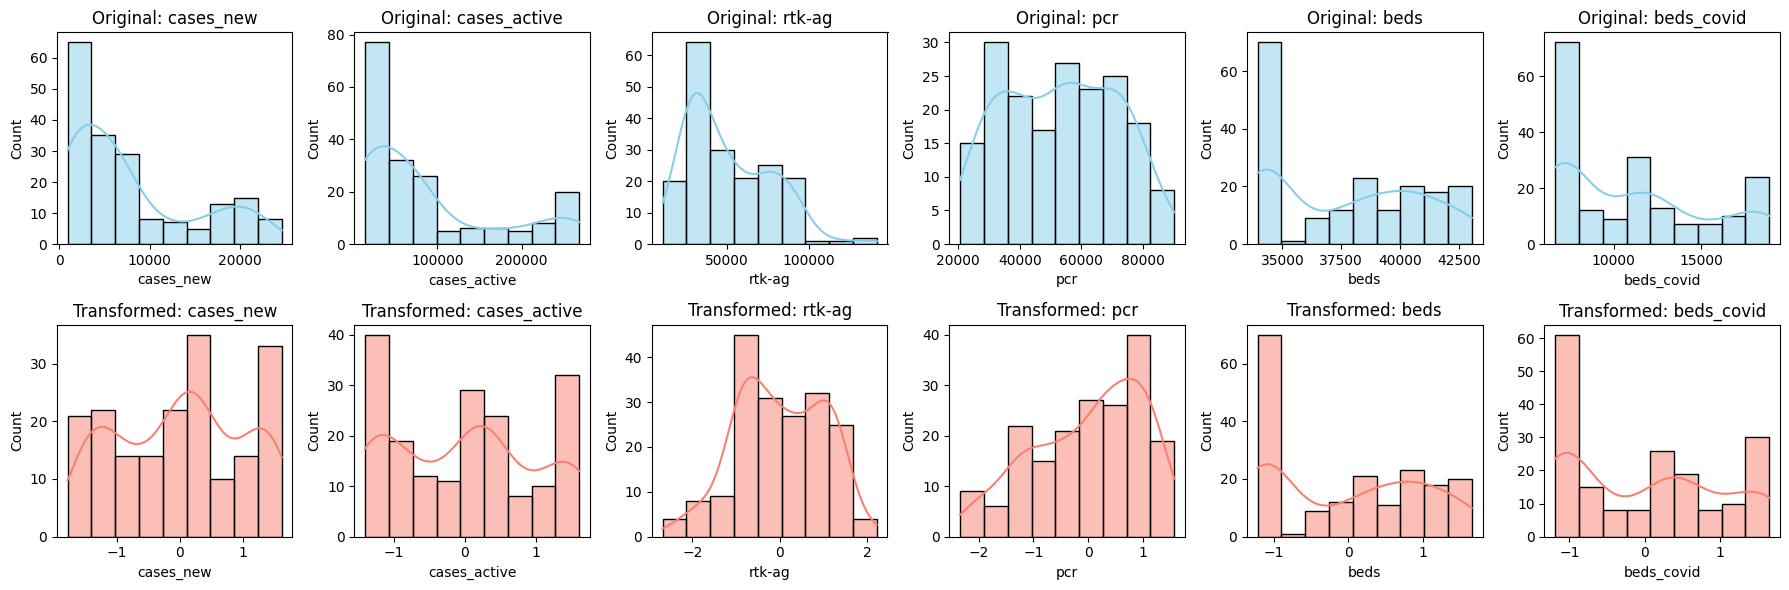

In [89]:
# Original features before selection
original_features = df.drop(columns=['date', 'risk_level'], errors="ignore")

# Features after selection and transformations (Part 3.1 & 3.2)
processed_features = X.copy()

# Plot distributions before and after feature engineering
num_features_to_plot = min(6, len(processed_features.columns))  # plot a few examples
sample_cols = processed_features.columns[:num_features_to_plot]

plt.figure(figsize=(18, 6))

for i, col in enumerate(sample_cols, 1):
    plt.subplot(2, num_features_to_plot, i)
    sns.histplot(original_features[col], kde=True, color='skyblue')
    plt.title(f'Original: {col}')
    
    plt.subplot(2, num_features_to_plot, i + num_features_to_plot)
    sns.histplot(processed_features[col], kde=True, color='salmon')
    plt.title(f'Transformed: {col}')

plt.tight_layout()
plt.show()

### Part 3.4: Feature Creation (Lagging)

**Objective:** Create lag features from past 8–14 days to predict **next week's Covid-19 risk level**.

**Reasoning:**  
- Using data from 8–14 days prior captures **recent trends** without using data from the prediction week (prevents look-ahead bias).  
- Shifting the target 7 days forward aligns with **next week’s risk** prediction.  
- Converting features and targets to integers ensures **consistency for model input**, especially for KNN.

In [90]:
# Create lagged features dictionary
lag_data = {}
start_lag = 8
end_lag = 14
for col in features.columns:
    for lag in range(start_lag, end_lag + 1):
        lag_data[f"{col}_lag{lag}"] = X[col].shift(lag)

# Convert to DataFrame
lagged_features = pd.DataFrame(lag_data)
lagged_features["date"] = df["date"]

# Shift target backward by 7 days to represent next week's risk
df["risk_level_next_week"] = df["risk_level"].shift(-7)

# Combine lagged features with target
df_weekly = pd.concat([lagged_features, df["risk_level_next_week"]], axis=1)

# Drop rows with NaNs
df_weekly = df_weekly.dropna().reset_index(drop=True)

# Convert all feature columns to integers
feature_cols = df_weekly.drop(columns=["date", "risk_level_next_week"]).columns
df_weekly[feature_cols] = df_weekly[feature_cols].astype(int)

# Convert target to integer
df_weekly["risk_level_next_week"] = df_weekly["risk_level_next_week"].astype(int)

# Final dataset for modeling
X_final = df_weekly.drop(columns=["date", "risk_level_next_week"])
y_final = df_weekly["risk_level_next_week"]

print("Feature matrix shape:", X_final.shape)
print("Target vector shape:", y_final.shape)


Feature matrix shape: (164, 133)
Target vector shape: (164,)
